<h1>Week 8: ARIMA-Models</h1>

<br>
1 Autoregressive- (AR) and Moving Average (MA) models<br>
2 Predicting with ARMA und ARIMA models<br>
3 Considering seasonality with SARIMA models<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
em = pd.read_csv("em_HH8_2012_05.csv", index_col=0)
em['Time'] = pd.to_datetime(em['Time'])
em.set_index('Time', inplace=True)
em.index.freq = 'H'
em.head()

,Electricity
Time,
2012-05-01 00:00:00,834.0
2012-05-01 01:00:00,824.0
2012-05-01 02:00:00,681.0
2012-05-01 03:00:00,530.0
2012-05-01 04:00:00,672.0


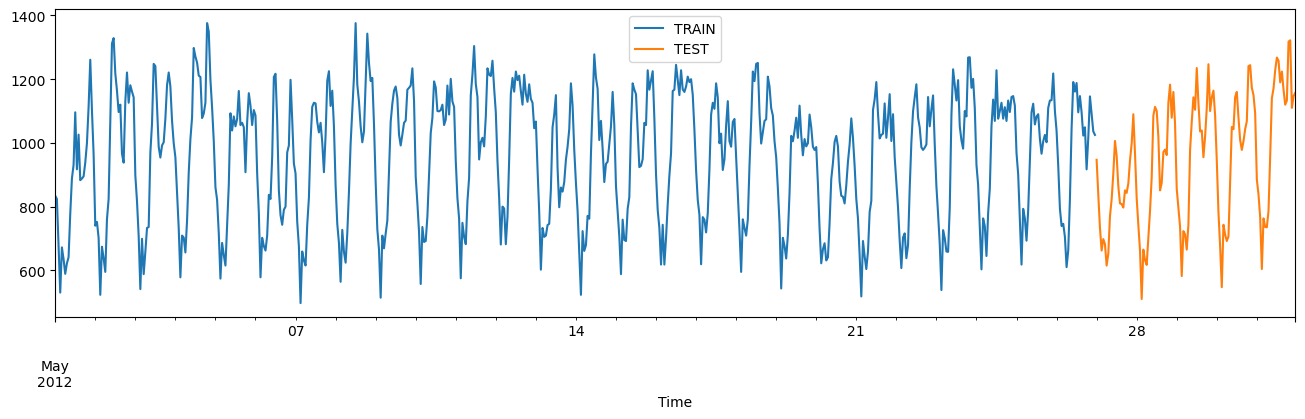

In [4]:
train_em = em[:624]
test_em = em[624:]
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4));

<h3> Naiv One Step</h3>

In [5]:
train_em.tail()

,Electricity
Time,
2012-05-26 19:00:00,1016.0
2012-05-26 20:00:00,1146.0
2012-05-26 21:00:00,1092.0
2012-05-26 22:00:00,1036.0
2012-05-26 23:00:00,1025.0


In [34]:
naiv = pd.DataFrame()
naiv = naiv.reindex_like(test_em)
#naiv = naiv.assign('Strom'==last)
naiv['Strom'] = train_em.iloc[623]['Strom']
naiv.columns = ['Naive Vorhersage']
naiv.head()

,Naive Vorhersage
Zeit,
2012-05-27 00:00:00,1025.0
2012-05-27 01:00:00,1025.0
2012-05-27 02:00:00,1025.0
2012-05-27 03:00:00,1025.0
2012-05-27 04:00:00,1025.0


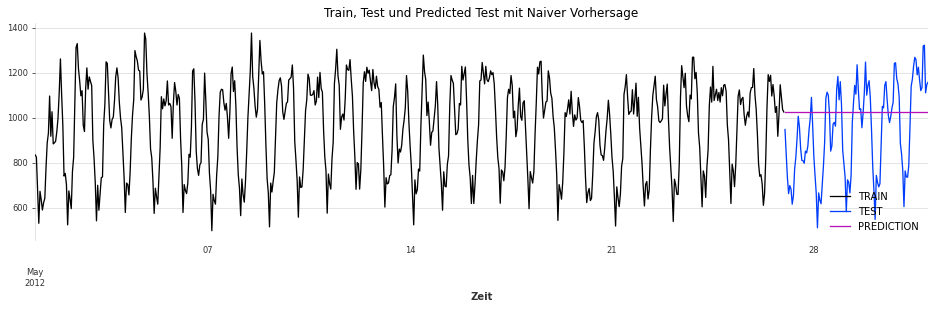

In [35]:
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
naiv['Naive Vorhersage'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit Naiver Vorhersage');

<h3> ARIMA models: Can we apply this method? </h3>

Is our time series stationary?<br>
Dickey-Fuller-Test (null hypothesis: not stationary)

In [36]:
testresults = adfuller(train_em)
print("Test statistic = {:.2f}".format(testresults[0]))
print("p-Value = {:.2f}".format(testresults[1]))
print("Number of lags = {:.2f}".format(testresults[2]))
print("Number of observations = {:.2f}".format(testresults[3]))
print("Critical value at 1% = {:.2f}".format(testresults[4]["1%"]))
print("Critical value at 5% = {:.2f}".format(testresults[4]["5%"]))
print("Critical value at 10% = {:.2f}".format(testresults[4]["10%"]))

Test statistic = -5.39
p-Value = 0.00
Number of lags = 19.00
Number of observations = 604.00
Critical value at 1% = -3.44
Critical value at 5% = -2.87
Critical value at 10% = -2.57


<h3> ARIMA models: determine p,d,q, P,D,Q, m </h3>

<h3>Geometric information from the ACF and PACF function</h3>

The ACF and PACF curves should be considered together to define the process. For an AR process, we expect the ACF curve to gradually decrease and at the same time the PACF curve to show a sharp drop after p significant delays. To define an MA process, we expect the ACF and PACF graphs to show the opposite, i.e., the ACF should show a sharp drop after a certain number q of lags, while the PACF should show a geometric or gradually decreasing trend. On the other hand, if both the ACF and PACF curves show a gradually decreasing pattern, then the ARMA process should be considered for modeling.

We can select the order p for the AR(p) model based on significant spikes from the PACF diagram. Anything outside the blue boundary of the PACF diagram gives an indication of the order of the AR model.

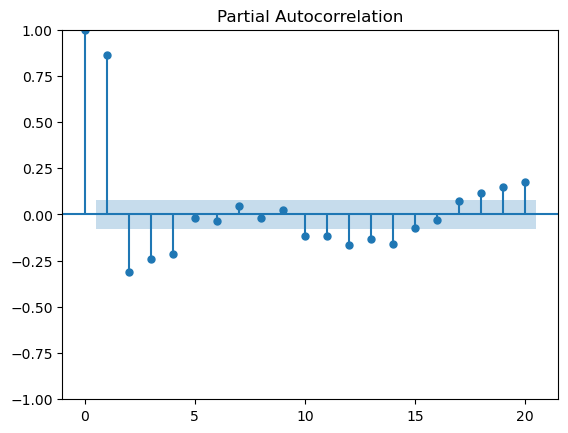

In [6]:
plot_pacf(train_em, lags=20, method='ywm');

In [7]:
for_mod = SARIMAX(train_em, 
              order=(1, 0, 0))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9943      0.005    220.238      0.000       0.985       1.003
sigma2      1.071e+04    715.485     14.968      0.000    9307.184    1.21e+04


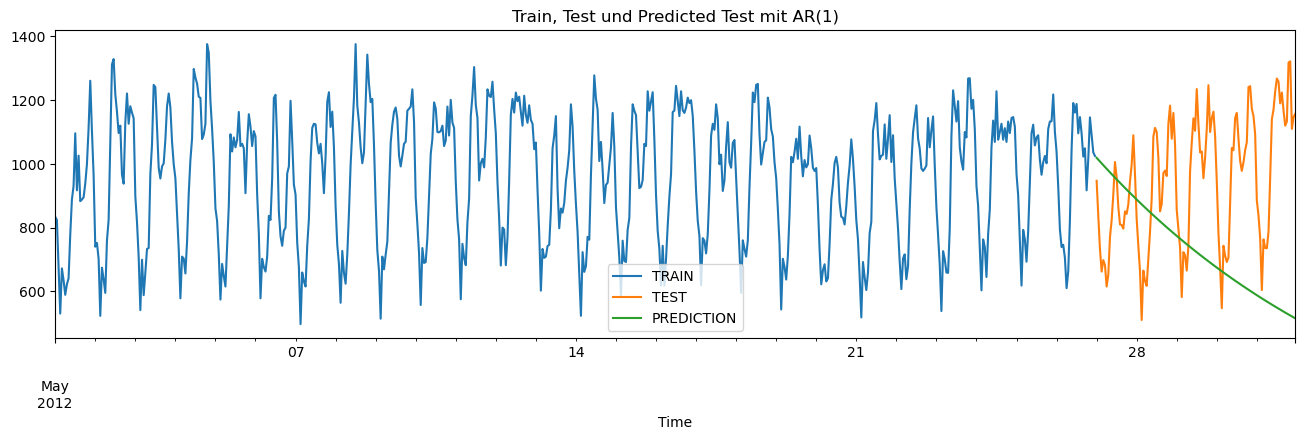

In [9]:
for_pred = for_results.get_forecast(steps=120)
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit AR(1)');

Im Gegensatz zum AR-Modell kann die Ordnung q für das Modell MA(q) aus dem ACF ausgewählt werden, wenn dieses Diagramm einen scharfen Cut-off nach dem Lag q aufweist.

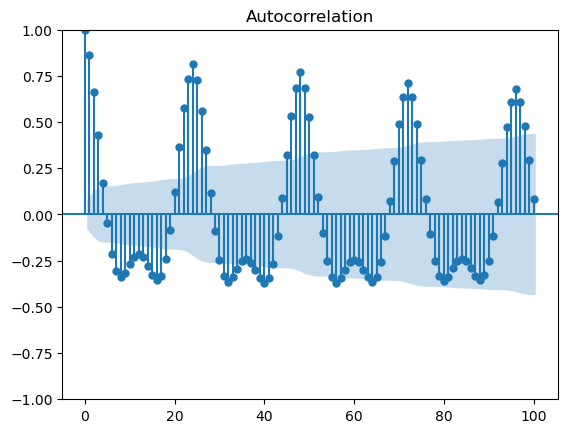

In [10]:
plot_acf(train_em, lags=100);

In [11]:
warnings.filterwarnings("ignore")
for_mod = SARIMAX(train_em, 
              order=(1, 0, 3))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9877      0.007    143.589      0.000       0.974       1.001
ma.L1          0.2112      0.042      5.080      0.000       0.130       0.293
ma.L2          0.1584      0.044      3.573      0.000       0.071       0.245
ma.L3          0.1681      0.044      3.785      0.000       0.081       0.255
sigma2      9891.8857    633.869     15.606      0.000    8649.526    1.11e+04


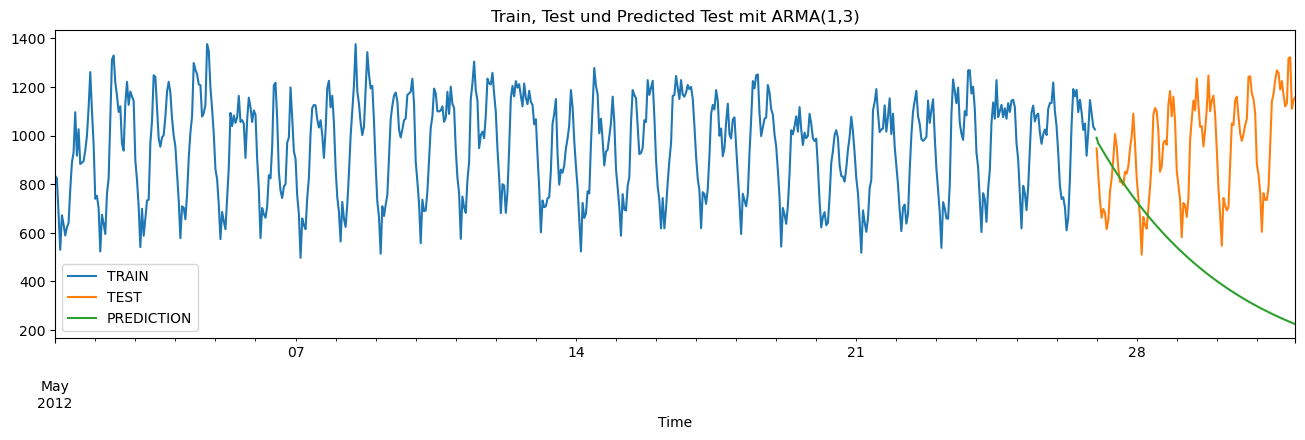

In [13]:
for_pred = for_results.get_forecast(steps=120)
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit ARMA(1,3)');

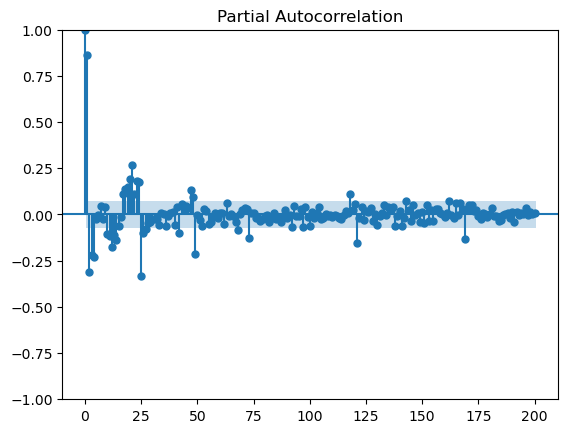

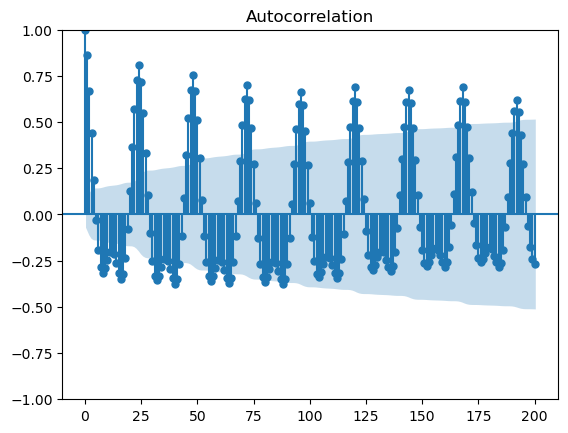

In [14]:
plot_pacf(em, lags=200, method='ywm');plot_acf(em, lags=200);

In [15]:
#warnings.filterwarnings("ignore")
for_mod = SARIMAX(train_em, 
              order=(1, 0, 3), 
              seasonal_order=(1, 0, 1, 24))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9797      0.010     96.160      0.000       0.960       1.000
ma.L1         -0.3037      0.041     -7.449      0.000      -0.384      -0.224
ma.L2         -0.2170      0.040     -5.454      0.000      -0.295      -0.139
ma.L3         -0.1317      0.040     -3.259      0.001      -0.211      -0.053
ar.S.L24       0.9988      0.001   1182.122      0.000       0.997       1.000
ma.S.L24      -0.8996      0.032    -28.010      0.000      -0.963      -0.837
sigma2      3579.3159    193.238     18.523      0.000    3200.577    3958.055


In [16]:
for_mod = SARIMAX(train_em, 
              order=(2, 0, 3), 
              seasonal_order=(1, 0, 1, 24))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0135      0.006      2.082      0.037       0.001       0.026
ar.L2          0.9865      0.006    152.559      0.000       0.974       0.999
ma.L1          0.6785      0.049     13.902      0.000       0.583       0.774
ma.L2         -0.5738      0.056    -10.297      0.000      -0.683      -0.465
ma.L3         -0.2643      0.047     -5.670      0.000      -0.356      -0.173
ar.S.L24       0.9969      0.003    332.043      0.000       0.991       1.003
ma.S.L24      -0.8937      0.050    -17.998      0.000      -0.991      -0.796
sigma2      6088.3614    328.930     18.510      0.000    5443.671    6733.052


In [17]:
for_pred = for_results.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit SARIMA(1,0,3)(1,0,1)24');

KeyError: 'Strom'

Zur Validierung des Modells z.B. prüfen, ob die Residuen, also die geschätzten $\epsilon_t$, unkorreliert sind und sich wie weißes Rauschen verhalten.

In [ ]:
for_results.plot_diagnostics(figsize=(16, 8))
plt.show()

<h3>How good is my model?</h3>

Reminder:<br>
Mean Absolute Error Holt-Winter = 87<br>
Mean Squared Error Holt-Winter = 11600

In [18]:
y_tru = test_em
y_SARIMA = for_pred.predicted_mean
errors = [['Mean Absolute Error', 87, mean_absolute_error(y_tru,y_SARIMA)], ['Mean Squared Error', 11600, mean_squared_error(y_tru,y_SARIMA)]] 
errors = pd.DataFrame(errors, columns = ['Art des Fehlers','Holt-Winters Vorhersage','SARIMA Vorhersage']) 
errors.set_index('Art des Fehlers', inplace=True) 
errors = round(errors, 2)
errors 

,Holt-Winters Vorhersage,SARIMA Vorhersage
Art des Fehlers,,
Mean Absolute Error,87,77.57
Mean Squared Error,11600,10064.43


<h3> Model identification: Determine (p,d,q)(P,D,Q)  </h3>
You can determine the parameters even more systematically - or have them determined

In [ ]:
# -> dauert evtl lange (ca. 1-2 Min)...
warnings.filterwarnings("ignore")
p = q = range(0, 3)
d = 0
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, [d], q))]
print(pdq)
print(seasonal_pdq)
df = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = SARIMAX(train_em,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        d = {
            'non-seasonal' : param,
            'seasonal' : param_seasonal,
            'AIC' : results.aic
        }
        df.append(d)
df = pd.DataFrame(df)
df['AIC'] = df['AIC'].astype(float)
df.to_csv('pdqPDQ.csv') 

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2)]
[(0, 0, 0, 24), (0, 0, 1, 24), (0, 0, 2, 24), (1, 0, 0, 24), (1, 0, 1, 24), (1, 0, 2, 24), (2, 0, 0, 24), (2, 0, 1, 24), (2, 0, 2, 24)]


In [ ]:
pdq = pd.read_csv("pdqPDQ.csv")
pdq = pdq.drop(columns=['Unnamed: 0'])
print('Beispiele...')
print(pdq.head())
print('Minimum AIC bei')
print(pdq[ pdq['AIC'] == pdq['AIC'].min() ])

<div class="alert alert-info">
- Perform a SARIMA prediction for our test period using the proposed model<br>
(- Plotte die Ergebnisse deiner Vorhersage in den obigen Plot dazu (so, dass du auch die SARIMA-Ergebnisse mit händisch bestimmten Parametern im selben Plot hast))<br>
(- Passe die Labels an, so dass klar wird welche Linie was ist)<br>
- Wie sieht es aus? Kann man einen Unterschied erkennen?<br>
- Bestimme zu deiner Analyse die Fehlermaße und füge sie in die obige Tabelle ein<br>
- Welche SARIMA-Analyse schneidet besser ab? Warum denkst du ist das so?
</div>

In [49]:
for_mod0 = SARIMAX(train_em, 
              order=(1, 1, 1), 
              seasonal_order=(1, 1, 1, 24))
for_results0 = for_mod0.fit()
print(for_results0.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5674      0.047     11.978      0.000       0.475       0.660
ma.L1         -0.9175      0.022    -41.042      0.000      -0.961      -0.874
ar.S.L24      -0.0850      0.045     -1.894      0.058      -0.173       0.003
ma.S.L24      -0.8790      0.034    -25.925      0.000      -0.945      -0.813
sigma2      3585.6322    190.013     18.870      0.000    3213.214    3958.050


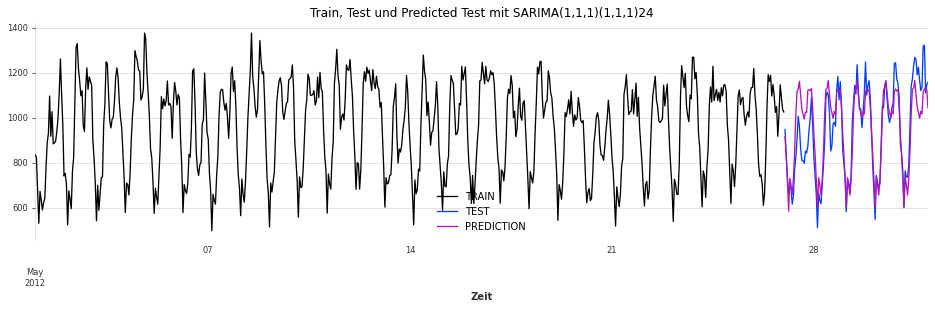

In [50]:
for_pred0 = for_results0.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred0.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit SARIMA(1,1,1)(1,1,1)24');

In [51]:
for_mod1 = SARIMAX(train_em, 
              order=(2, 0, 3), 
              seasonal_order=(1, 0, 1, 24))
for_results1 = for_mod1.fit()
print(for_results1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0042      0.001      3.694      0.000       0.002       0.006
ar.L2          0.9958      0.001    875.572      0.000       0.994       0.998
ma.L1          0.6258      0.011     58.972      0.000       0.605       0.647
ma.L2         -0.4963      0.003   -155.443      0.000      -0.503      -0.490
ma.L3         -0.1285      0.001   -167.625      0.000      -0.130      -0.127
ar.S.L24       0.9976      0.001    788.743      0.000       0.995       1.000
ma.S.L24      -0.9232      0.009   -100.984      0.000      -0.941      -0.905
sigma2      5059.7174     84.282     60.034      0.000    4894.529    5224.906


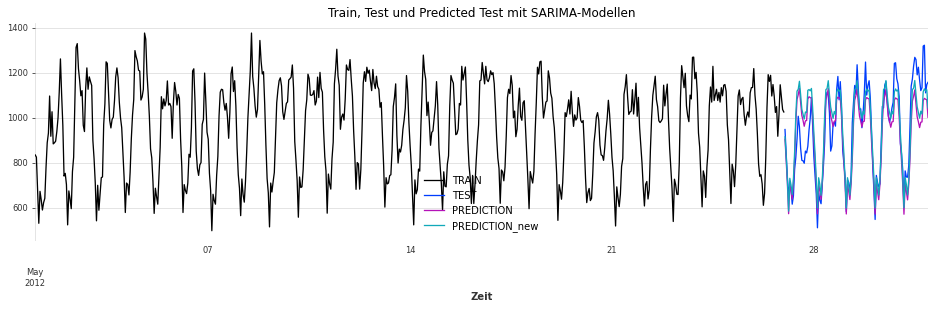

In [52]:
for_pred1 = for_results1.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred1.predicted_mean.plot(legend=True,label='PREDICTION')
for_pred0.predicted_mean.plot(legend=True,label='PREDICTION_new')
plt.title('Train, Test und Predicted Test mit SARIMA-Modellen');

In [53]:
y_tru = test_em
y_SARIMA0 = for_pred0.predicted_mean
y_SARIMA1 = for_pred1.predicted_mean
errors = [['Mean Absolute Error', mean_absolute_error(y_tru,y_SARIMA1), mean_absolute_error(y_tru,y_SARIMA0)], ['Mean Squared Error', mean_squared_error(y_tru,y_SARIMA1), mean_squared_error(y_tru,y_SARIMA0)]] 
errors = pd.DataFrame(errors, columns = ['Art des Fehlers','Händische SARIMA Vorhersage','Automatische SARIMA Vorhersage']) 
errors.set_index('Art des Fehlers', inplace=True) 
errors = round(errors, 2)
errors 

,Händische SARIMA Vorhersage,Automatische SARIMA Vorhersage
Art des Fehlers,,
Mean Absolute Error,77.15,72.41
Mean Squared Error,9885.07,9183.88
